In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import sys
sys.path.append('../utils')
sys.path.append('../dFC')
import widefield_utils
import connectivity_measures

In [3]:
mask = np.load(r"/home/k21208334/calcium_analyses/data/dowsampled_tight_mask.npy")
good_indices = np.ravel(mask)

In [15]:
h=300
w=304
H=50 # this is the size of downsampling. We have to find a better way to do this
W=51
start = 0
end = 25000

names = ["NXAK22.1A","NXAK14.1A","NXAK7.1B","NXAK4.1B","NRXN78.1D","NRXN78.1A"]
names_knock = ["NXAK24.1C","NXAK20.1B","NXAK16.1B","NXAK10.1A","NXAK4.1A","NRXN71.2A"]

n_comp = 10 # i choose this n of components because it's the most convincing

In [25]:
signals = np.load('/home/k21208334/calcium_analyses/data/ICA/signals_n=' + str(n_comp) + '.npy')
components = np.load('/home/k21208334/calcium_analyses/data/ICA/components_n=' + str(n_comp) + '.npy')

In [6]:
# For each component, I compare each ICA component absolute amplitude and I do walking vs non walking

In [7]:
# create walking timeseries note the cool python command I use:
walking_wild = np.concatenate([np.load('/home/k21208334/calcium_analyses/data/walking/'+name+'.npy') for name in names])
walking_knock = np.concatenate([np.load('/home/k21208334/calcium_analyses/data/walking/'+name+'.npy') for name in names_knock])


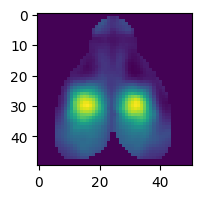

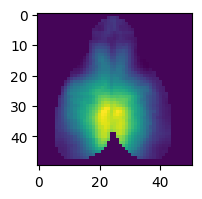

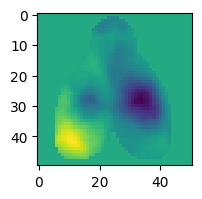

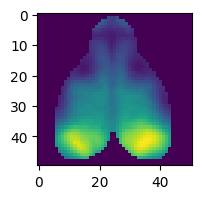

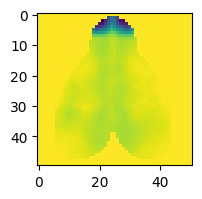

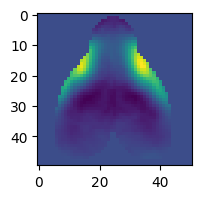

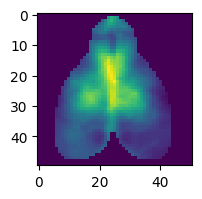

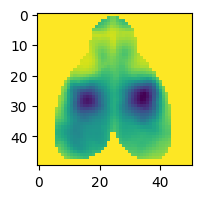

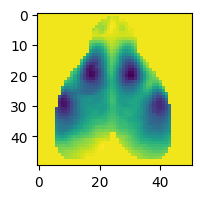

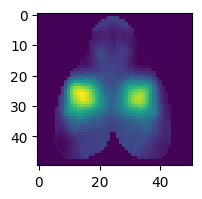

In [9]:
for i in range(n_comp):
    fig = connectivity_measures.show_array(comps[:,i],H,W,good_indices)
    fig.set_size_inches(2,2)

In [ ]:
# now do ICA clustering on raw amplitude signals exactly the same way as LEiDA clustering

In [10]:
signals.shape

(300000, 10)

/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

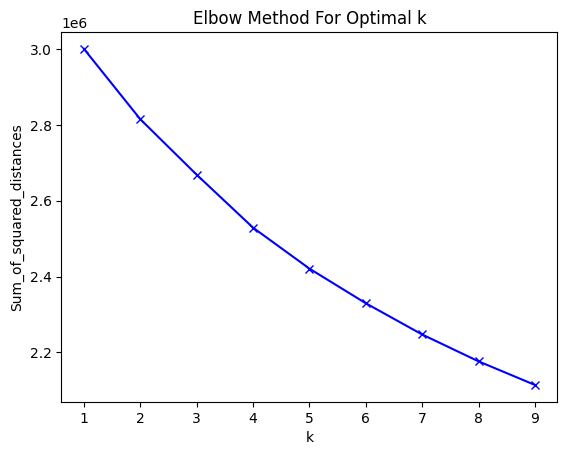

In [11]:
# plot elbow method to see number of clusters

from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(signals)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [12]:
# we decide that our k is 5
k = 5

km = KMeans(n_clusters=k)
km = km.fit(signals)

/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [27]:
# let's define fractional occupancies. REALITY is just a dream which is good enough to make us survive.

n_individuals = len(names+names_knock)
fractional_occupancies_walk = np.zeros((n_individuals,k))
fractional_occupancies_rest = np.zeros((n_individuals,k))
fractional_occupancies_all = np.zeros((n_individuals,k))
avg_abs_speed = np.zeros((n_individuals,1))

for i,name in enumerate(names+names_knock):
    for j in range(k):
        walking = np.load('/home/k21208334/calcium_analyses/data/walking/'+name+'.npy')
        timeseries_labels = km.labels_[int(i*end):int((i+1)*end)]==j
        fractional_occupancies_walk[i,j] = np.sum(timeseries_labels[walking])/len(timeseries_labels[walking])
        fractional_occupancies_rest[i,j] = np.sum(timeseries_labels[~walking])/len(timeseries_labels[~walking])
        fractional_occupancies_all[i,j] = np.sum(timeseries_labels)/end
    avg_abs_speed[i] = np.mean(np.abs(np.load('/home/k21208334/calcium_analyses/data/raw_speed/'+name+'.npy')))

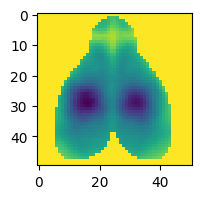

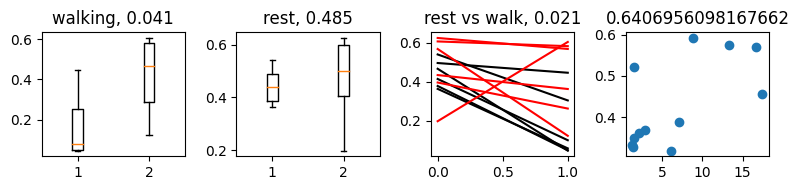

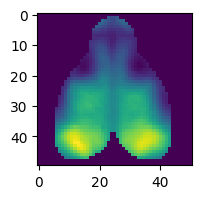

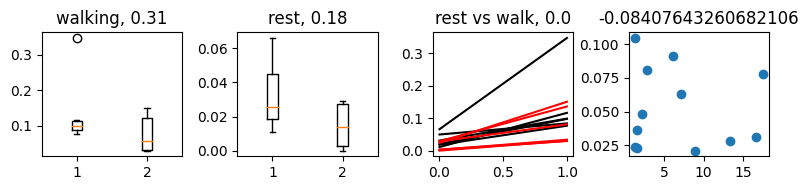

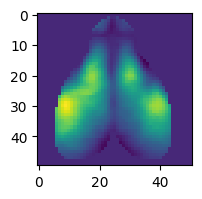

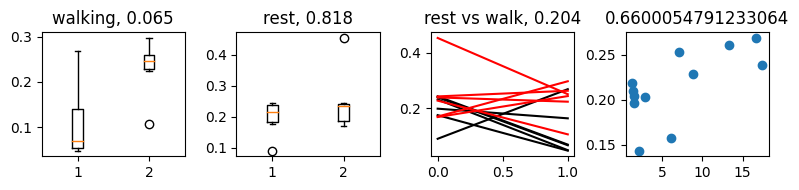

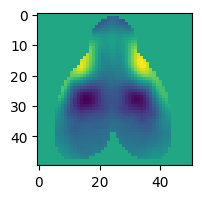

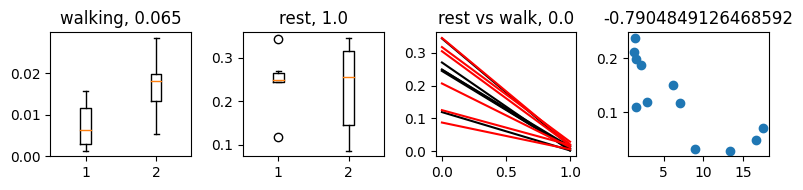

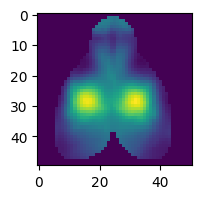

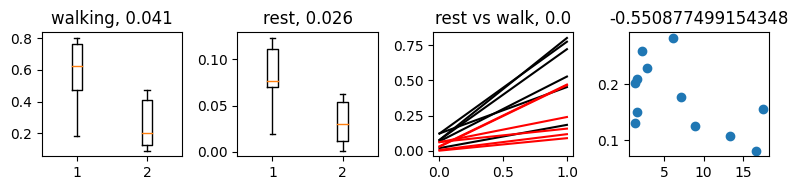

In [41]:
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon


cluster_centers = km.cluster_centers_
centroids = np.dot(components,cluster_centers.T)

for i,centroid in enumerate(centroids.T):
    fig = connectivity_measures.show_array(centroid,H,W,good_indices)
    fig.set_size_inches(2,2)
    
    fig,ax = plt.subplots(1,4)
    fig.set_size_inches(8,2)
    ax[0].boxplot([fractional_occupancies_walk[0:6,i],fractional_occupancies_walk[6:12,i]])
    test = mannwhitneyu(fractional_occupancies_walk[0:6,i],fractional_occupancies_walk[6:12,i])
    pvalue = test.pvalue
    ax[0].set_title('walking, '+str(round(pvalue,3)))
    
    ax[1].boxplot([fractional_occupancies_rest[0:6,i],fractional_occupancies_rest[6:12,i]])
    test = mannwhitneyu(fractional_occupancies_rest[0:6,i],fractional_occupancies_rest[6:12,i])
    pvalue = test.pvalue
    ax[1].set_title('rest, '+str(round(pvalue,3)))
    
    # try also statistics on walk vs non walk as a control...
    ax[2].plot([fractional_occupancies_rest[0:6,i],fractional_occupancies_walk[0:6,i]],color='black')
    ax[2].plot([fractional_occupancies_rest[6:12,i],fractional_occupancies_walk[6:12,i]],color='red')
    test = wilcoxon(fractional_occupancies_rest[:,i],fractional_occupancies_walk[:,i])
    pvalue = test.pvalue
    ax[2].set_title('rest vs walk, '+str(round(pvalue,3)))
    fig.tight_layout()
    
    ax[3].scatter(avg_abs_speed.T,fractional_occupancies_all[:,i])
    ax[3].set_title(str(np.corrcoef(avg_abs_speed.T,fractional_occupancies_all[:,i])[1,0]))
    
    